<img src="./Dados/Group 2.png" alt="header"></img>

# BCG X Challenge - Amigos do Bem

**Transformando o sertão com dados!**

O Amigos do Bem é uma organização sem fins lucrativos que atua há 30 anos no sertão nordestino, transformando vidas por meio de ações de educação, saúde, trabalho e renda. A organização atende mais de 150 mil pessoas em 300 povoados, localizadas em 3 estados do Nordeste: Alagoas, Ceará e Pernambuco.

Com o passar dos anos, a ONG viu a necessidade de expandir para novos municípios e impactar novas famílias. Cabe destacar que não trata-se de uma escolha trivial para a próxima cidade a ser atendida, pois a ONG precisa levar em consideração diversos fatores de priorização. Além disso, pensando em atender a agenda de *trabalho*, também considera-se a preocupação com a atividade econômica desenvolvida, pensando na melhor que se adaptaria e deteria maior potencial de renda.

Dessa forma, o desafio propõe a criação de um modelo de priorização de municípios para a expansão da ONG e quais atividades econômicas devem ser desenvolvidas em cada um deles.


Grupo 14

Integrantes:
- <a src="https://www.linkedin.com/in/marcos-vinicius-166531239/">Marcos Vinícius Moura</a>
- <a src="https://www.linkedin.com/in/priscila-falcão-3435a1244/">Priscila Falcão</a>
- <a src="https://www.linkedin.com/in/raphael-lisboa/">Raphael Lisboa Antunes</a>
- <a src="https://github.com/BartonThomas">Thomas Barton</a>

---

## 1. Importação de bibliotecas

Inicialmente, importou-se algumas bibliotecas que seriam posteriormente utilizadas dentro do projeto.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import geopandas as gpd
from shapely.geometry import Point
import random

## 2. Processo OSEMN

Para o desenvlvimento do projeto, a equipe optou por seguir o processo de ciência de dados OSEMN, recomendado pela Amazon Web Service e seguido por diversas outras grandes empresas. Consiste em:
- Obter os dados: extração dos dados de bancos de dados internos ou externos.
- Suprimir os dados: a supressão de dados, ou limpeza de dados, é o processo de padronização dos dados de acordo com um formato predeterminado.
- Explorar os dados: é uma análise de dados preliminar que é usada para planejar outras estratégias de modelagem de dados. 
- Modelar os dados:  os algoritmos de software e machine learning são usados para obter insights mais profundos, prever resultados e prescrever o melhor plano de ação.
- Interpretar os dados: os dados são interpretados para obter insights e identificar padrões. São feitos diagramas, gráficos e tabelas para representar tendências e previsões.



Fonte: < https://aws.amazon.com/pt/what-is/data-science/>.

### a) Obtenção dos dados -  importação das bases de dados disponíveis

In [2]:
# Leitura dos dados dos municípios do semiárido

cities = pd.read_excel("Dados/Municipios/lista-1262municipios-semiarido-2017.xlsx")
cities = cities.rename(columns=cities.iloc[1])
cities = cities.drop([0, 1]).reset_index(drop=True)
cities = cities.drop('#', axis=1).reset_index(drop=True)

In [3]:
# Leitura dos dados referentes a todos os municipios do Brasil

all_cities = pd.read_csv("Dados/Municipios/municipios.csv")
all_cities = all_cities[(all_cities['codigo_ibge'].isin(cities['Cod IBGE']))]

In [4]:
# Leitura dos dados do censo brasileiro

census = pd.read_csv("Dados/Censo/Censo_municipal_estadual_nacional-MUN91-00-10.csv")
census = census[(census['Codmun7'].isin(cities['Cod IBGE']))]
census_siglas = pd.read_csv("Dados/Censo/Censo_municipal_estadual_nacional-Siglas.csv")

In [5]:
# Leitura dos dados dos registros administrativos

idh_tot = pd.read_csv("Dados/Registros_Administrativos/dados_registros_administrativos_total_2012_2027.csv")

Uso de dados externos para fins de complemento da informação extraídos de: < https://www.ibge.gov.br/cidades-e-estados.html>.

In [6]:
# Dados de municípios do sertão nordestino pegos do site oficial do IBGE por estado, tratados e concatenados em um único csv

data_ibge = pd.read_csv("Dados/Dados IBGE/Dados IBGE.csv")
data_ibge = data_ibge[(data_ibge['Munic&iacute;pio [-]'].isin(cities['Cod IBGE']))]

In [7]:
# Informações dos estados do sertão nordestino pegos do site oficial do IBGE

all_states = pd.read_csv("Dados/Dados IBGE/Estados IBGE.csv")
all_states = all_states[all_states['C&oacute;digo [-]'].isin(all_cities['codigo_uf'])]

### b) Supressão dos dados - tratamento das bases de dados

Para o uso dos dados, observou-se que seria necessário realizar um tratamento inicial, de forma a deixar os dados mais limpos e organizados. Além disso, os arquivos em formato .xlsx estavam configurados de forma ilegível para o notebook, assim, alguns deles foram convertidos para .csv, enquanto outros tiveram as suas primeiras linhas (as que não continham informações relevantes) excluídas.

#### **Filtro dos municípios**

In [8]:
# Junção das informações de identificação e IDHs das bases de dado de registros administrativos e censo

idh_tot_to_merge = idh_tot.drop_duplicates(subset='IBGE7', keep='last').reset_index(drop=True)
census_to_merge = census.drop_duplicates(subset='Codmun7', keep='last').reset_index(drop=True)
census_idh_merged = pd.merge(idh_tot_to_merge[['IBGE7', 'NOME', 'POP_TOT']], census_to_merge[['Codmun7', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']], left_on='IBGE7', right_on='Codmun7', how='inner')
df = census_idh_merged.drop('Codmun7', axis=1)

In [9]:
# Adição das informações territoriais (estado, latitude e longitude)

df = pd.merge(df, cities[['Cod IBGE', 'UF']], left_on='IBGE7', right_on='Cod IBGE', how='inner')
df = pd.merge(df, all_cities[['codigo_ibge', 'latitude', 'longitude']], left_on='IBGE7', right_on='codigo_ibge', how='inner')
df = df.drop(['Cod IBGE', 'codigo_ibge'], axis=1)
df = df.sort_values(by='IBGE7')

In [10]:
# Adição das informações de área do município e densidade demográfica

data_ibge = data_ibge.sort_values(by='Munic&iacute;pio [-]').reset_index(drop=True)
df['AREA_KM²'] = data_ibge['Prefeito [2021]']
df['POP/KM²'] = data_ibge['Popula&ccedil;&atilde;o residente - pessoas [2022]']

In [11]:
# Análise dos municípios em que os Amigos do Bem já atuam, ordenados por IDHM

df[(df['IBGE7'].isin([2602803, 2607000, 2308104, 2708402]))].sort_values(by=['IDHM'])

,IBGE7,NOME,POP_TOT,IDHM,IDHM_E,IDHM_L,IDHM_R,UF,latitude,longitude,AREA_KM²,POP/KM²
753,2607000,Inajá,22801,0.523,0.400,0.711,0.503,PE,-8.90206,-37.8351,1231.362,20.79
722,2602803,Buíque,57696,0.527,0.395,0.746,0.497,PE,-8.61954,-37.1606,1336.544,38.98
861,2708402,São José da Tapera,32626,0.527,0.409,0.703,0.508,AL,-9.55768,-37.3831,490.879,62.35
290,2308104,Mauriti,46548,0.605,0.526,0.772,0.544,CE,-7.38597,-38.7708,1079.011,42.22


### c) Exploração dos dados - análise exploratória dos dados

Para obter uma conclusão assertiva, analisou-se os dados de forma a identificar padrões e tendências. Além disso, foram feitas análises estatísticas e qualitativas, de forma a obter uma visão mais ampla dos dados. A partir dessas análises, definiu-se parâmetros e chegou-se em respostas satisfatórias para o problema proposto.

#### **Definição de parâmetros**

Assim, após as análises iniciais, principalmente das cidades já atendidas pela ONG, foram definidos alguns parâmetros para a seleção das cidades que seriam priorizadas para a expansão da ONG. Notou-se que a maioria das cidades atendidas possuíam uma população com mais de 15 mil habitantes antes da chegada dos Amigos do Bem. Neste sentido, foi definido que as cidades com população menor que 15 mil habitantes não seriam priorizadas, considerando também o potencial de impacto, haja vista que uma cidade com maior população, possui mais chances de impactar mais famílias. Além disso, foi definido que as cidades com IDH maior que 0,55 também não seriam priorizadas, uma vez que esse seria o valor da média nordestina e o foco seria aqueles que estivessem em situações mais alarmantes, com menor indicador de desenvolvimento humano.

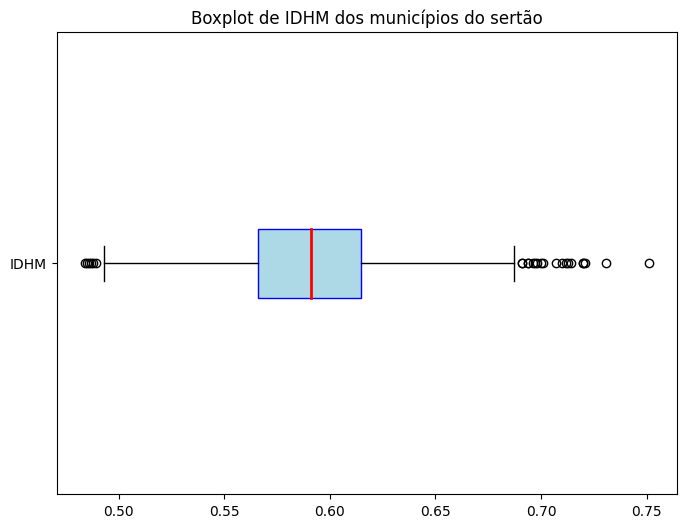

In [12]:
# Distribuição dos municípios do sertão organizados pelo IDHM para a identificação dos outliers de menor valor

data = df['IDHM']

fig, ax = plt.subplots(figsize=(8, 6))

boxplot = ax.boxplot(data, patch_artist=True, vert=False)

for patch in boxplot['boxes']:
    patch.set(facecolor='lightblue', edgecolor='blue')
for median in boxplot['medians']:
    median.set(color='red', linewidth=2)

ax.set_yticklabels(['IDHM'])
ax.set_title('Boxplot de IDHM dos municípios do sertão')

plt.show()

O boxplot é um gráfico altamente utilizado para analisar a distribuição dos dados, nele é possível identificarmos os elementos centrais e extremos. Por meio do gráfico analisado, podemos concluir que os menores valores se encontram em uma faixa de IDHM abaixo de 0.5.

In [13]:
# Municípios do sertão com IDHM menor ou igual a 0.5 ordenados (a média do sertão é 0.52; fonte - https://www.amigosdobem.org/porque-o-sertao/)

df[df['IDHM'] <= 0.5].sort_values(by='IDHM')

,IBGE7,NOME,POP_TOT,IDHM,IDHM_E,IDHM_L,IDHM_R,UF,latitude,longitude,AREA_KM²,POP/KM²
840,2703304,Inhapi,18652,0.484,0.316,0.718,0.501,AL,-9.22594,-37.7509,372.019,40.77
151,2209658,São Francisco de Assis do Piauí,5657,0.485,0.336,0.734,0.462,PI,-8.23599,-41.6873,1072.311,5.20
1016,2916500,Itapicuru,36211,0.486,0.319,0.711,0.505,BA,-11.30880,-38.2262,1557.685,20.34
769,2609154,Manari,21047,0.487,0.354,0.682,0.477,PE,-8.96490,-37.6313,344.685,68.94
49,2202653,Caxingó,5330,0.488,0.329,0.708,0.498,PI,-3.41904,-41.8955,491.093,11.19
23,2201739,Betânia do Piauí,6106,0.489,0.342,0.702,0.486,PI,-8.14376,-40.7989,579.576,10.73
851,2706000,Olivença,11772,0.493,0.345,0.677,0.513,AL,-9.51954,-37.1954,175.288,61.68
50,2202703,Cocal,27338,0.497,0.334,0.712,0.516,PI,-3.47279,-41.5546,1294.133,21.80
52,2202729,Cocal dos Alves,6054,0.498,0.315,0.779,0.504,PI,-3.62047,-41.4402,324.856,19.66
14,2201051,Assunção do Piauí,7717,0.499,0.382,0.706,0.462,PI,-5.86500,-41.0389,1690.703,4.41


In [14]:
# Municípios com população maior ou igual a 15000 e IDHM menor ou igual a 0.5 ordenados

df[(df['POP_TOT'] >= 15000) & (df['IDHM'] < 0.5)].sort_values(by='IDHM')

,IBGE7,NOME,POP_TOT,IDHM,IDHM_E,IDHM_L,IDHM_R,UF,latitude,longitude,AREA_KM²,POP/KM²
840,2703304,Inhapi,18652,0.484,0.316,0.718,0.501,AL,-9.22594,-37.7509,372.019,40.77
1016,2916500,Itapicuru,36211,0.486,0.319,0.711,0.505,BA,-11.30880,-38.2262,1557.685,20.34
769,2609154,Manari,21047,0.487,0.354,0.682,0.477,PE,-8.96490,-37.6313,344.685,68.94
50,2202703,Cocal,27338,0.497,0.334,0.712,0.516,PI,-3.47279,-41.5546,1294.133,21.80


In [15]:
# Ordenação de estados por IDH

all_states.sort_values(by='IDH &lt;span&gt;Índice de desenvolvimento humano&lt;/span&gt; [2021]')

,UF [-],C&oacute;digo [-],Gent&iacute;lico [-],Governador [2023],Capital [2010],&Aacute;rea Territorial - km&sup2; [2022],Popula&ccedil;&atilde;o residente - pessoas [2022],Densidade demogr&aacute;fica - hab/km&sup2; [2022],Matrículas no ensino fundamental - matr&iacute;culas [2021],IDH &lt;span&gt;Índice de desenvolvimento humano&lt;/span&gt; [2021],Receitas realizadas - R$ (&times;1000) [2017],Despesas empenhadas - R$ (&times;1000) [2017],Rendimento mensal domiciliar per capita - R$ [2022],Total de ve&iacute;culos - ve&iacute;culos [2022]
9,Maranh&atilde;o,21,maranhense,CARLOS ORLEANS BRAND&Atilde;O J&Uacute;NIOR,S&atilde;o Lu&iacute;s,329651.496,6775152,20.55,1112636,0.676,1.850326e+07,1.762717e+07,814,2031236
1,Alagoas,27,alagoano,PAULO SURUAGY DO AMARAL DANTAS,Macei&oacute;,27830.661,3127511,112.38,458782,0.684,1.195044e+07,1.046063e+07,935,1034187
17,Piau&iacute;,22,piauiense,RAFAEL TAJRA FONTELES,Teresina,251755.481,3269200,12.99,459871,0.690,1.212422e+07,9.676736e+06,1110,1385426
4,Bahia,29,baiano,JER&Ocirc;NIMO RODRIGUES SOUZA,Salvador,564760.429,14136417,25.03,1946957,0.691,5.019100e+07,4.557016e+07,1010,4887673
14,Para&iacute;ba,25,paraibano,JO&Atilde;O AZEVEDO LINS FILHO,Jo&atilde;o Pessoa,56467.242,3974495,70.39,540919,0.698,1.309701e+07,1.007470e+07,1096,1523167
25,Sergipe,28,sergipano ou sergipense,F&Aacute;BIO CRUZ MITIDIERI,Aracaju,21938.188,2209558,100.72,320638,0.702,1.014505e+07,8.494927e+06,1187,907388
16,Pernambuco,26,pernambucano,RAQUEL TEIXEIRA LYRA LUCENA,Recife,98067.877,9058155,92.37,1249850,0.719,3.574603e+07,3.332049e+07,1010,3439164
19,Rio Grande do Norte,24,potiguar ou norte-rio-grandense ou rio-grand...,MARIA DE FATIMA BEZERRA,Natal,52809.599,3302406,62.53,447692,0.728,1.352755e+07,1.133096e+07,1267,1495094
5,Cear&aacute;,23,cearense,ELMANO DE FREITAS DA COSTA,Fortaleza,148894.447,8791688,59.05,1161434,0.734,2.842022e+07,2.460835e+07,1050,3625994
12,Minas Gerais,31,mineiro,ROMEU ZEMA NETO,Belo Horizonte,586513.983,20538718,35.02,2407107,0.774,9.719982e+07,9.839167e+07,1529,13028883


Ademais, também achou-se necessário entender o conceito do macro, ou seja, como era o desenvolvimento do estado em que a cidade estava inserida. Para isso foram selecionados os valores de IDHM, IDHM-E, IDHM-L e IDHM-R de cada estado presente no semiárido brasileiro, a partir da média das cidades dessa região (região do semiárido). Com isso foi possível perceber uma necessidade de atuação nos estados de Alagoas e Piauí (dois estados também citados na listagem das cidades com menores IDHM). 

In [16]:
# Valores de IDH por estado, pegando a média dos IDHMs das cidades de cada estado

df.groupby('UF')[['IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']].mean().sort_values(by='IDHM')

,IDHM,IDHM_E,IDHM_L,IDHM_R
UF,,,,
AL,0.550763,0.424947,0.739342,0.533632
PI,0.570832,0.456903,0.747827,0.547308
MA,0.585000,0.490500,0.738500,0.555500
PE,0.585154,0.473504,0.749797,0.566748
BA,0.585554,0.475133,0.754540,0.562388
SE,0.586000,0.472345,0.745207,0.574103
PB,0.588541,0.478737,0.757345,0.564144
RN,0.609762,0.516354,0.762707,0.577395
MG,0.613231,0.504132,0.792835,0.579209


#### Qual deve ser o próximo município de atuação?

Por fim, para a definição final de cidades que deveriam ser priorizadas na atuação, montou-se um dataset reunindo todas as cidades com os menores IDHMs da região e que possuíam uma população maior que 6 000 habitantes. A mudança foi realizada a fim de observar as demais cidades que não passavam pelo parâmetro definido anteriormente, mas que dependendo da distância que estivessem das outras cidades (tanto as que seriam escolhidas, quanto as já atendidas), poderiam receber suporte indiretamente, contribuindo com a escolha pelo cálculo de potencial de impacto.

Nota-se que também foram adicionados os dados de distância de cada cidade em relação as outras cidade que já existem atuação. Isso porque acreditou-se na relevância que a logística possuía na escolha das cidades, além de respeitar a dinâmica natural que a ONG já possui de expansão para as regiões próximas.
Todos os dados de distância foram retirados do site oficial do Google Maps, ferramenta de localização.

Fonte: < https://www.google.com/maps/@-6.6901781,-36.8983389,8.01z?entry=ttu>.

In [17]:
# Definição de quais seriam as cidades para a realização da escolha e a análise estratégica
final_towns = df[(df['POP_TOT'] >= 6000) & (df['IDHM'] < 0.52)].copy().reset_index(drop=True)

transport = pd.read_csv("Dados/Transportes/transport_cost.csv")
trasnport = transport[(transport['codigo_ibge'].isin(final_towns['IBGE7']))]
min_cost_indexes = transport.groupby('codigo_ibge')['transportation_cost'].idxmin()
transport = transport.loc[min_cost_indexes].sort_values(by=['codigo_ibge'])
final_towns['CUSTO_TRANSPORTE'] = transport['transportation_cost'].reset_index(drop=True)
final_towns = final_towns.sort_values(by='IDHM')

# Seleção dos 10 mais precárias
final_towns = final_towns[0:10]

# Adição de colunas de distância a fim de analisar a logística de transporte e expansão
final_towns['DIST_MAURITI_KM'] = [432, 578, 255, 334, 470, 724, 718, 430, 446, 440]
final_towns['DIST_INAJA_KM'] = [43.4, 358, 31.6, 493, 110, 1066, 1060, 755, 29.4, 395]
final_towns['DIST_CATIMBAU_KM'] = [148, 453, 82.7, 523, 175, 1087, 1039, 734, 143, 489]
final_towns['DIST_TORROES_KM'] = [65.7, 287, 100, 581, 31.2, 1154, 1148, 828, 94, 385]

final_towns

,IBGE7,NOME,POP_TOT,IDHM,IDHM_E,IDHM_L,IDHM_R,UF,latitude,longitude,AREA_KM²,POP/KM²,CUSTO_TRANSPORTE,DIST_MAURITI_KM,DIST_INAJA_KM,DIST_CATIMBAU_KM,DIST_TORROES_KM
14,2703304,Inhapi,18652,0.484,0.316,0.718,0.501,AL,-9.22594,-37.7509,372.019,40.77,30826.16075,432,43.4,148.0,65.7
18,2916500,Itapicuru,36211,0.486,0.319,0.711,0.505,BA,-11.30880,-38.2262,1557.685,20.34,31404.04957,578,358.0,453.0,287.0
10,2609154,Manari,21047,0.487,0.354,0.682,0.477,PE,-8.96490,-37.6313,344.685,68.94,28086.86221,255,31.6,82.7,100.0
1,2201739,Betânia do Piauí,6106,0.489,0.342,0.702,0.486,PI,-8.14376,-40.7989,579.576,10.73,40326.18358,334,493.0,523.0,581.0
16,2706000,Olivença,11772,0.493,0.345,0.677,0.513,AL,-9.51954,-37.1954,175.288,61.68,29448.76531,470,110.0,175.0,31.2
2,2202703,Cocal,27338,0.497,0.334,0.712,0.516,PI,-3.47279,-41.5546,1294.133,21.80,33091.35869,724,1066.0,1087.0,1154.0
3,2202729,Cocal dos Alves,6054,0.498,0.315,0.779,0.504,PI,-3.62047,-41.4402,324.856,19.66,32666.08672,718,1060.0,1039.0,1148.0
0,2201051,Assunção do Piauí,7717,0.499,0.382,0.706,0.462,PI,-5.86500,-41.0389,1690.703,4.41,40478.94761,430,755.0,734.0,828.0
15,2705002,Mata Grande,25589,0.504,0.369,0.685,0.506,AL,-9.11824,-37.7323,914.722,23.88,29052.57418,446,29.4,143.0,94.0
20,2921500,Monte Santo,51953,0.506,0.359,0.699,0.515,BA,-10.43740,-39.3321,3034.197,15.75,30576.64853,440,395.0,489.0,385.0


Dessa forma, concluiu-se que as opções de cidades que deveriam ser priorizadas para a expansão da ONG seriam:
- Inhapi, AL: Segundo IBGE, Alagoas é o estado com o segundo menor IDH, além da segunda menor Receita realizada em 2017. Contabilizando as médias entre as cidades do semiárido, Alagoas entra como o primeiro menor IDH. Está em quarto menor despesas empenhadas. Além disso, tem o segundo menor rendimento e está com a pior nos índices de educação e renda, de acordo com a média de cidades do semiárido. E ainda com a segunda pior média de longevidade. Vale destacar, que Inhapi é a cidade com o menor IDHM, ressaltando a necessidade de atuação mais próxima da ONG e um alto potencial de impacto, visto a população de mais de 18 000 habitantes (valor tal muito próximo a média de população das cidades atendidas pela ONG, na época em que essa começou a desenvolver atividades nelas). Ademais, vale destacar localização, sendo muito próxima de Inajá, cidade que já é atendida pela ONG, Inhapi ainda conta com proximidade com outros municípios que precisariam de apoio, como Manari, Mata Grande e Olivença, que apesar de populações menores, possuem IDHMs igualmente baixos e poderiam ser afetados indiretamente com a atuação em Inhapi.

- Cocal, PI: Segundo o IBGE, o Piauí ocupa o terceiro lugar de IDH mais baixo, além disso, também tem a terceira menor receita e segunda menor despesa empenhada. Ademais, se forem considerados por IDHMs pela média por cidade, têm o segundo pior IDHM-E e IDHM-R. Além disso, tem o terceiro pior em longevidade. Soma-se isso a estatística de que das 10 cidades resgatadas com os menores valores de IDHM e com população acima de 6000 habitantes, de 10, 4 são do Piauí. Dessa forma, a cidade de Cocal foi escolhida, considerando sua população de mais de 27 000 habitantes, em adição com o baixo IDHM e sua localização próximo a outras duas cidades também em subdesenvolvimento (Cocal dos Alves e Caxingó) que poderiam ser afetadas indiretamente. Destaca-se que esse não tem proximidade com nenhuma cidade já atendida pela ONG, contudo a instalação em uma nova localidade seria propício para o crescimento descentralizado e a oportunidade de atuação em novas regiões.


### d) Modelação dos dados

Pensando em uma análise mais sofisticada dos fatores de impacto e dados selecionados, foi decidido com suporte de profissionais do BCGX o uso de machine learning para identificação e comprovação da relevância de alguns índices para o objetivo final: aumentar o IDHM das cidades afetadas, através da melhora da qualidade de vida, educação e renda.

#### **Correlação dos dados**

Uma matriz de correlação ajuda a entender como as variáveis no seu conjunto de dados estão relacionadas entre si. Através da análise das correlações, é possível identificar se existem associações positivas ou negativas entre variáveis. Isso é fundamental para compreender a natureza dos dados e pode ser usado para gerar insights.

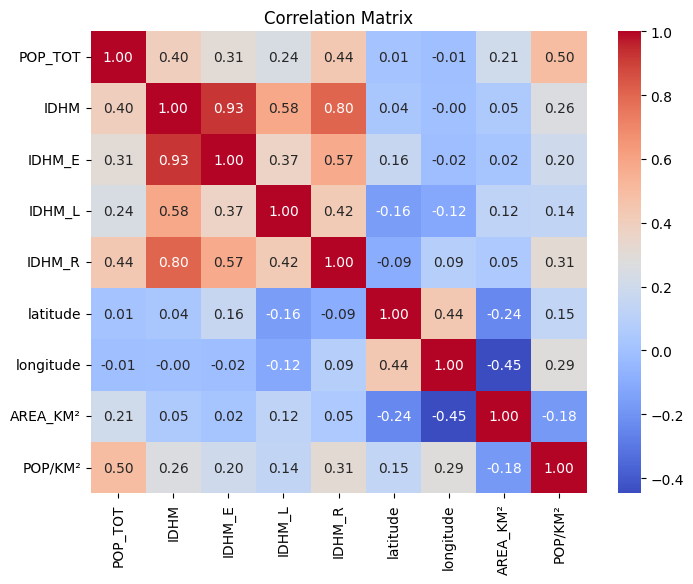

In [18]:
# Correlação dos dados do dataframe tratado

correlation_df = df.copy()
correlation_df = correlation_df.drop(['IBGE7', 'NOME', 'UF'], axis=1)
correlation_matrix = correlation_df.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

Text(0, 0.5, 'IDHM_E')

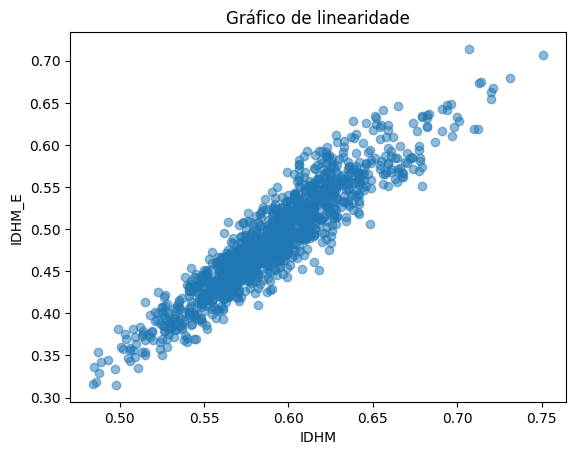

In [19]:
# Gráfico mostrando a linearidade entre os valores de IDHM e IDHM_E

x = df['IDHM']
y = df['IDHM_E']

df[(df['POP_TOT'] >= 15000) & (df['IDHM'] < 0.52)]['IDHM']

plt.scatter(x, y, alpha=0.5)
plt.title('Gráfico de linearidade')
plt.xlabel('IDHM')
plt.ylabel('IDHM_E')

**IDHM_E:** Existe uma correlação forte e positiva entre o Índice de Desenvolvimento Humano Municipal (IDHM) e o subíndice de Educação (IDHM_E). Isso sugere que um bom desempenho em indicadores educacionais está associado a um IDH mais alto.

**IDHM_R:** O subíndice de Renda (IDHM_R) também apresenta uma correlação positiva com o IDHM, embora um pouco menos forte do que a correlação com o IDHM_E.

**População e Área Geográfica:** A análise revela também que os dados de população e área geográfica dos municípios têm correlações relativamente baixas com o IDH. No entanto, destaca-se que a densidade populacional tem uma influência ligeiramente maior no IDH, em comparação com outras variáveis relacionadas à população e área.

#### **Modelo preditivo**

Para obter uma visão mais completa e aprofundada dos dados que estamos observando, aplicamos um modelo preditivo. Essa abordagem vai além da mera análise descritiva, permitindo-nos identificar relações de dados mais complexas e ver a correlação dos dados com uma maior profundidade.

In [20]:
# Separação dos dados para treinar o modelo preditivo

data = census.copy()
X = data.drop(['ANO', 'Codmun6', 'Codmun7', 'Município'], axis=1).dropna()
y = X['IDHM']
X = X.drop(['IDHM'], axis=1)

In [21]:
# Criação, hiperparametrização e treinamento do modelo, utilizando a biblioteca LightGBM

hyper_params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'learning_rate': 0.05,
    "num_iterations": 100,
}


gbm = lgb.LGBMRegressor(**hyper_params)
gbm.fit(X, y)

C:\Users\thoma\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 57256
[LightGBM] [Info] Number of data points in the train set: 1262, number of used features: 232
[LightGBM] [Info] Start training from score 0.591554


LGBMRegressor(learning_rate=0.05, num_iterations=100, objective='regression',
              task='train')

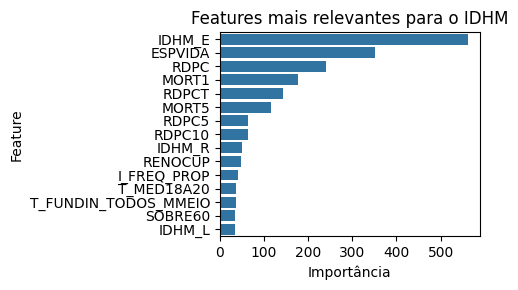

In [22]:
# Gráfico demonstrando as 15 colunas que mais influenciam na predição, com seus respectivos pesos

feature_importance = pd.DataFrame(sorted(zip(gbm.feature_importances_, X.columns), reverse=True), columns=['Importância', 'Feature'])
top_20_features = feature_importance.head(15)

plt.figure(figsize=(5, 3))
sns.barplot(x="Importância", y="Feature", data=top_20_features)
plt.title('Features mais relevantes para o IDHM')
plt.tight_layout()
plt.show()

**IDHM_E:** Como demonstrado na matriz de correlação, aqui também foi possível identificar que o subíndice de Educação (IDHM_E) apresenta uma influência significativa no valor do IDHM. Essa correlação forte destaca a importância dos indicadores educacionais no cálculo do IDHM.

**Ênfase em Variáveis de Renda:** Além disso, a observação dos atributos mais destacados pelo modelo de previsão reforça a presença significativa de dados relacionados à renda. Isso sugere que o poder aquisitivo e a distribuição de renda têm um papel considerável na determinação do IDHM.

**Impacto da Mortalidade e Longevidade:** A análise revela que as variáveis relacionadas à mortalidade e longevidade desempenham um papel mais significativo do que inicialmente aparentado (na matriz de correlação). Essas variáveis emergem repetidamente na lista de características de maior importância, sublinhando sua influência substancial no cálculo do IDHM.

### e) Interpretação dos resultados - Análise dos custos e ganhos

Por fim, após ter sido estabelecido os parâmetros de escolha das cidades, selecionado quais seriam os próximos municípios e compreendido quais os principais fatores que influenciavam no resultado final, foi feita uma análise de possíveis atividades econômicas a serem desenvolvidas, além do custo e ganho que seria investido e arrecadado.

No mais, também foram realizados cálculos de potencial de impacto que a atuação da ONG poderia ter em cada um dos municípios.

#### **Transporte**

In [23]:
# Análise dos custos de transporte dos municípios

final_towns.sort_values(by='CUSTO_TRANSPORTE')

,IBGE7,NOME,POP_TOT,IDHM,IDHM_E,IDHM_L,IDHM_R,UF,latitude,longitude,AREA_KM²,POP/KM²,CUSTO_TRANSPORTE,DIST_MAURITI_KM,DIST_INAJA_KM,DIST_CATIMBAU_KM,DIST_TORROES_KM
10,2609154,Manari,21047,0.487,0.354,0.682,0.477,PE,-8.96490,-37.6313,344.685,68.94,28086.86221,255,31.6,82.7,100.0
15,2705002,Mata Grande,25589,0.504,0.369,0.685,0.506,AL,-9.11824,-37.7323,914.722,23.88,29052.57418,446,29.4,143.0,94.0
16,2706000,Olivença,11772,0.493,0.345,0.677,0.513,AL,-9.51954,-37.1954,175.288,61.68,29448.76531,470,110.0,175.0,31.2
20,2921500,Monte Santo,51953,0.506,0.359,0.699,0.515,BA,-10.43740,-39.3321,3034.197,15.75,30576.64853,440,395.0,489.0,385.0
14,2703304,Inhapi,18652,0.484,0.316,0.718,0.501,AL,-9.22594,-37.7509,372.019,40.77,30826.16075,432,43.4,148.0,65.7
18,2916500,Itapicuru,36211,0.486,0.319,0.711,0.505,BA,-11.30880,-38.2262,1557.685,20.34,31404.04957,578,358.0,453.0,287.0
3,2202729,Cocal dos Alves,6054,0.498,0.315,0.779,0.504,PI,-3.62047,-41.4402,324.856,19.66,32666.08672,718,1060.0,1039.0,1148.0
2,2202703,Cocal,27338,0.497,0.334,0.712,0.516,PI,-3.47279,-41.5546,1294.133,21.80,33091.35869,724,1066.0,1087.0,1154.0
1,2201739,Betânia do Piauí,6106,0.489,0.342,0.702,0.486,PI,-8.14376,-40.7989,579.576,10.73,40326.18358,334,493.0,523.0,581.0
0,2201051,Assunção do Piauí,7717,0.499,0.382,0.706,0.462,PI,-5.86500,-41.0389,1690.703,4.41,40478.94761,430,755.0,734.0,828.0


#### Qual atividade econômica a ser desenvolvida em cada região?

Para definir qual atividade econômica seria desenvolvida em cada um dos municípios, pensou-se no estudo das maiores e mais rentáveis agriculturas de cada região. Assim, de acordo com os resultados da busca, selecionou-se as mais viáveis de serem implementadas em cada.

#### **Agricultura**

Para a busca dos produtos possíveis foram coletados dados do site do IBGE, disponível em: < https://www.ibge.gov.br/explica/producao-agropecuaria/pi> - estado do Piauí e < https://www.ibge.gov.br/explica/producao-agropecuaria/al> - estado de Alagoas. Cabe destacar que os dados estavam divididos em municípios, permitindo uma análise mais acurada do plantio cabível para cada uma das propostas.

In [24]:
# Importando dados da agricultura dos municípios

agriculture = pd.read_csv("Dados/Agricultura/Agricultura.csv")
agriculture['Área destinada à colheita (Hectares)'] = agriculture['Área destinada à colheita (Hectares)'].fillna(agriculture['Área plantada (Hectares)']).combine_first(agriculture['Área plantada (Hectares)'].fillna(agriculture['Área destinada à colheita (Hectares)']))
agriculture = agriculture.drop('Área plantada (Hectares)', axis=1)

Cocal

In [25]:
agriculture[agriculture['Municipio'] == '      Cocal'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)[:5]

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
48,Cocal,5196.0,5196.0,57156.0,11000.0,29721.0,2022; Mandioca
46,Cocal,5825.0,5825.0,1631.0,280.0,6932.0,2022; Feijão (em grão)
38,Cocal,4422.0,4422.0,1548.0,350.0,5418.0,2022; Castanha de caju
50,Cocal,5774.0,5774.0,4041.0,700.0,4849.0,2022; Milho (em grão)
52,Cocal,355.0,355.0,1118.0,3149.0,3253.0,2022; Soja (em grão)


Cocal dos Alves

In [26]:
agriculture[agriculture['Municipio'] == '      Cocal dos Alves'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
49,Cocal dos Alves,940.0,940.0,9400.0,10000.0,4700.0,2022; Mandioca
39,Cocal dos Alves,3441.0,3441.0,1307.0,380.0,4444.0,2022; Castanha de caju
47,Cocal dos Alves,965.0,965.0,286.0,296.0,1401.0,2022; Feijão (em grão)
51,Cocal dos Alves,965.0,965.0,675.0,699.0,911.0,2022; Milho (em grão)


Caxingó

In [27]:
agriculture[agriculture['Municipio'] == '      Caxingó'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)[:5]

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
31,Caxingó,424.0,424.0,737.0,1738.0,995.0,2022; Arroz (em casca)
33,Caxingó,94.0,94.0,940.0,10000.0,470.0,2022; Mandioca
32,Caxingó,101.0,101.0,40.0,396.0,160.0,2022; Feijão (em grão)
35,Caxingó,101.0,101.0,71.0,703.0,96.0,2022; Milho (em grão)
34,Caxingó,5.0,5.0,87.0,17400.0,87.0,2022; Melancia


Inhapi

In [28]:
agriculture[agriculture['Municipio'] == '      Inhapi'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)[:5]

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
21,Inhapi,76.0,76.0,720.0,9474.0,865.0,2022; Mandioca
23,Inhapi,25.0,25.0,550.0,22000.0,686.0,2022; Melancia
25,Inhapi,7.0,7.0,180.0,25714.0,450.0,2022; Melão
27,Inhapi,1600.0,160.0,133.0,831.0,211.0,2022; Milho (em grão)
19,Inhapi,1540.0,95.0,55.0,579.0,210.0,2022; Feijão (em grão)


Mata Grande

In [29]:
agriculture[agriculture['Municipio'] == '      Mata Grande'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)[:5]

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
30,Mata Grande,100.0,100.0,4200.0,42000.0,10391.0,2022; Tomate
26,Mata Grande,80.0,70.0,2310.0,33000.0,6122.0,2022; Melão
24,Mata Grande,152.0,152.0,3691.0,24283.0,4066.0,2022; Melancia
22,Mata Grande,190.0,190.0,1740.0,9158.0,2182.0,2022; Mandioca
1,Mata Grande,73.0,73.0,1052.0,14411.0,2014.0,2022; Banana (cacho)


Manari

In [30]:
agriculture[agriculture['Municipio'] == '      Manari'].sort_values(by='Valor da produção (Mil Reais)', ascending=False)[:5]

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais),Plantação
53,Manari,950.0,210.0,68.0,324.0,282.0,2022; Feijão (em grão)
55,Manari,1200.0,390.0,146.0,374.0,212.0,2022; Milho (em grão)
54,Manari,14.0,14.0,59.0,4214.0,53.0,2022; Mandioca


Dados sobre todas as plantações - entendimento do rendimento e lucro de cada uma das plantações.

Assim, concluiu-se que a melhor atividade econômica a ser desenvolvida em geral, é a **plantação de mandioca**, tanto pela sua adaptabilidade ao clima seco do sertão, quanto pelo seu alto rendimento e lucro. 
Contudo, também é possível observar outras atividades que podem ser desenvolvidas em áreas específicas. Destaca-se:
- **Para Cocal e Cocal dos Alves**: produção de raiz de mandioca, feijão, castanha de caju e milho.
- **Para Caxingó**: produção de raiz de mandioca.
- **Para Inhapi**: produção de raiz de mandioca, e possibilidade de melancia e melão (plantação intermitente).
- **Mata Grande**: produção de raiz de mandioca, e possibilidade de tomate, melancia e melão (plantação intermitente).
- **Para Manari**: produção de raiz de mandioca, feijão, milho.

#### **Irrigação**

Visto que sabe-se a partir da tabela anterior analisada, quanto de produção se consegue por hectare de cada cultura, entende-se a importância de examinar a área plantável de cada região, pensando no potencial de rendimento que cada produto pode adiquirir.

In [31]:
# Importando dados de indicadores de água dos estados

atlas_irrigation = pd.read_csv("Dados/ANA/Atlas_irrigacao_UF.csv")
atlas_irrigation = atlas_irrigation[atlas_irrigation['UF - Sigla'].isin(["AL", "PI"])].reset_index(drop=True)
atlas_irrigation = atlas_irrigation.applymap(lambda x: x.replace(',', '') if isinstance(x, str) else x)

C:\Users\thoma\AppData\Local\Temp\ipykernel_3316\2982894015.py:5: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  atlas_irrigation = atlas_irrigation.applymap(lambda x: x.replace(',', '') if isinstance(x, str) else x)


In [32]:
# Configuração da coluna de "AAI - Potencial Efetivo"

atlas_irrigation["AAI - Potencial Efetivo"] = pd.to_numeric(atlas_irrigation["AAI - Potencial Efetivo"], errors='coerce')
atlas_irrigation.sort_values(by="AAI - Potencial Efetivo")

,Região,UF - Sigla,Unidade da Federação,Arroz Inundado,Café,Cana-de-Açúcar Irrigada,"Outras Culturas em Pivôs Centrais (exceto arroz, café e cana)","Pivôs Centrais - Total (considerando sobreposição com arroz, café e cana)",Outras culturas e sistemas,Área Total Irrigada,Cana-de-Açúcar Fertirrigada,Área Total (Irrigada e Fertirrigada),AAI com água superficial em agricultura de sequeiro,AAI com água superficial em pastagem,AAI com água subterrânea,AAI - Potencial Total,AAI - Potencial Efetivo
1,Nordeste,AL,Alagoas,3136,0,174370,791,1530,1719,180016,0,180016,22464,21078,2387,45929,17760
0,Nordeste,PI,Piauí,4700,0,20444,2234,2234,23215,50593,0,50593,97215,51950,26948,176113,18630


Nota-se que a área plantável potencial do estado de Alagoas é de 45 929 hectares, enquanto o de Piauí é de 176 113, mas vale ressaltar que foi considerado o valor de potencial efetivo, uma vez que esse é a área realmente viável de plantação. Assim, foram consideradas as áreas de 17 760 hectares para Alagoas e  18 630 hectares para Piauí como áreas potenciais de desenvolvimento de atividades.

Ainda, ressalta-se que essa é a área do estado, e não de cada município, uma vez que as plantações podem se estender para além da extensão territorial municipal.

#### **Custos de produção agrícola**


Avaliação dos custos por produção e atividade realizada.
Os dados foram retirados do site oficial do CONAB (Companhia Nacional de Abastecimento): <https://portaldeinformacoes.conab.gov.br/download-arquivos.html>.

In [33]:
# Importando dados de custo e lucro de produção segundo o CONAB

production_cost_conab = pd.read_csv("Dados/CONAB/custo_producao_conab.csv")
production_cost_conab["vlr_custo_variavel_ha"] = pd.to_numeric(production_cost_conab["vlr_custo_variavel_ha"], errors='coerce')
production_cost_conab["vlr_custo_fixo_ha"] = pd.to_numeric(production_cost_conab["vlr_custo_fixo_ha"], errors='coerce')
production_cost_conab["vlr_renda_fator_ha"] = pd.to_numeric(production_cost_conab["vlr_renda_fator_ha"], errors='coerce')

In [34]:
# Filtrando os dados para pegar os valores de custo fixo e variável por hectares mais recentes dos produtos e estados

production_costs = production_cost_conab[(production_cost_conab['empreendimento'].isin(["AGRICULTURA FAMILIAR"])) & 
                               (production_cost_conab['uf'].isin(["AL", "PI"])) & 
                               (production_cost_conab['produto'].isin(["RAIZ DE MANDIOCA", "CASTANHA DE CAJU", "FEIJAO", "MILHO", "TOMATE", "MELAO", "MELANCIA"])) &
                               (production_cost_conab['ano'].isin([2022]))
                               ]

costs = pd.DataFrame(production_costs.groupby(['produto', 'uf'])['vlr_custo_variavel_ha'].mean())
costs['vlr_custo_fixo_ha'] = production_costs.groupby(['produto', 'uf'])['vlr_custo_fixo_ha'].mean()
costs['custo_total_ha'] = costs['vlr_custo_variavel_ha'] + costs['vlr_custo_fixo_ha']
costs

vlr_custo_variavel_ha  vlr_custo_fixo_ha  custo_total_ha
produto          uf                                                          
CASTANHA DE CAJU PI               5302.340             665.17        5967.510
RAIZ DE MANDIOCA AL               8184.970            2427.95       10612.920
                 PI               5033.905             127.96        5161.865

Portanto, com o acúmulo de dados coletados e analisados, foi definido como custo de produção agrícola por hectare para cada um dos municípios:
- Cocal: 
    - Raiz de mandioca: R$ 5 967,51/hectare
    - Feijão: Não disponível
    - Castanha de caju: R$ 10 612,92/hectare
    - Milho: Não disponível
- Cocal dos Alves:
    - Raiz de mandioca: R$ 5 967,51/hectare
    - Feijão: Não disponível
    - Castanha de caju: R$ 10 612,92/hectare
    - Milho: Não disponível
- Caxingó: 
    - Raiz de mandioca: R$ 5 967,51/hectare
- Inhapi: 
    - Raiz de mandioca: R$ 10612.92/hectare
    - Melancia: Não disponível
    - Melão: Não disponível
- Mata Grande: 
    - Raiz de mandioca: R$ 10612.92/hectare
    - Tomate: Não disponível
    - Melancia: Não disponível 
    - Melão:Não disponível
- Manari: 
    - Raiz de mandioca: R$ 10612.92/hectare
    - Feijão: Não disponível
    - Milho: Não disponível


Nota-se que são aproximações e que foi considerado o valor de custo de produção agrícola por hectare para o estado, uma vez que não foi possível encontrar dados específicos para cada município. Além disso, os valores são do ano de 2022, podendo sofrer alterações com o passar do tempo, o que pode se traduzir em um valor acima do estimado ou abaixo.

#### **Rentabilidade da produção agrícola**

Avaliação da rentabilidade por produção e atividade realizada.

In [35]:
# Lucro de cada produto por estado

gain_production_conab = pd.read_csv("Dados/CONAB/lucro_producao_conab.csv")
gain_production = gain_production_conab[(gain_production_conab['produto'].isin(['FEIJAO', 'RAIZ DE MANDIOCA', 'MILHO', 'CASTANHA DE CAJU'])) & 
                                      (gain_production_conab['uf'].isin(['PI', 'AL'])) &
                                      (gain_production_conab['ano'].isin([2023]))]

gain_production = pd.DataFrame(gain_production.groupby(['ano','produto', 'uf', 'classificao_produto'])['valor_produto_kg'].mean())
gain_production

valor_produto_kg
ano  produto          uf classificao_produto                  
2023 CASTANHA DE CAJU AL EM CASCA                     5.435000
                      PI EM CASCA                     2.908889
     FEIJAO           AL CAUPI TIPO 1                 6.867222
                         COMUM CORES                  4.420000
                         COMUM CORES TIPO 1           9.101111
                         COMUM CORES TIPO 2           7.740000
                         COMUM PRETO TIPO 1           8.849444
                      PI CAUPI                        6.542500
                         CAUPI TIPO 1                 8.010556
                         COMUM CORES TIPO 1           8.020556
                         COMUM PRETO TIPO 1           7.708889
     MILHO            AL EM GRÃOS                     1.324545
                      PI EM GRÃOS                     1.116667
     RAIZ DE MANDIOCA AL PARA FARINHA                 0.826667
                      PI PARA FARINHA                 0.718889

In [36]:
profitability = agriculture.groupby('Plantação').sum().sort_values(by='Valor da produção (Mil Reais)', ascending=False)
profitability[:10]

,Municipio,Área destinada à colheita (Hectares),Área colhida (Hectares),Quantidade produzida (Toneladas),Rendimento médio da produção (Quilogramas por Hectare),Valor da produção (Mil Reais)
Plantação,,,,,,
2022; Mandioca,Inhapi Mata Grande Caxingó ...,6510.0,6510.0,70015.0,53846.0,37991.0
2022; Tomate,Inhapi Mata Grande,102.0,102.0,4282.0,83000.0,10599.0
2022; Castanha de caju,Inhapi Mata Grande Caxingó ...,7883.0,7883.0,2869.0,2980.0,9916.0
2022; Feijão (em grão),Inhapi Mata Grande Caxingó ...,10931.0,7416.0,2212.0,2475.0,9512.0
2022; Milho (em grão),Inhapi Mata Grande Caxingó ...,11140.0,7990.0,5606.0,4207.0,7143.0
2022; Melão,Inhapi Mata Grande,87.0,77.0,2490.0,58714.0,6572.0
2022; Melancia,Inhapi Mata Grande Caxingó,182.0,182.0,4328.0,63683.0,4839.0
2022; Soja (em grão),Cocal,355.0,355.0,1118.0,3149.0,3253.0
2022; Banana (cacho),Inhapi Mata Grande Cocal,87.0,87.0,1188.0,36411.0,2275.0


In [37]:
products = ['Castanha de caju', 'Castanha de caju', 'Feijao', 'Feijao', 'Milho', 'Milho','Raiz de mandioca', 'Raiz de mandioca']
UF = [ 'AL', 'PI', 'AL', 'PI', 'AL', 'PI', 'AL', 'PI']
value_kg = [5.43, 2.90, 9.10, 8.02, 1.32, 1.17, 0.83, 0.71]
kg_hectare = [2980, 2980, 2475, 2475, 4207, 4207, 53846, 53846]
calc_profit = pd.DataFrame(products, columns=["Produtos"])
calc_profit['UF'] = UF
calc_profit['value_kg'] = value_kg
calc_profit['Kg_hectare'] = kg_hectare
calc_profit['Rentabilidade por hectare'] = calc_profit['value_kg'] * calc_profit['Kg_hectare']
calc_profit

,Produtos,UF,value_kg,Kg_hectare,Rentabilidade por hectare
0,Castanha de caju,AL,5.43,2980,16181.40
1,Castanha de caju,PI,2.90,2980,8642.00
2,Feijao,AL,9.10,2475,22522.50
3,Feijao,PI,8.02,2475,19849.50
4,Milho,AL,1.32,4207,5553.24
5,Milho,PI,1.17,4207,4922.19
6,Raiz de mandioca,AL,0.83,53846,44692.18
7,Raiz de mandioca,PI,0.71,53846,38230.66


Assim, para cálculo da rentabilidade que cada produção poderia proporcionar, foi considerado: 
- os produtos produzidos por cada região; 
- o preço de 1kg de cada produto; 
- a produção em kg por hectare de cada produto;
- o rendimento por hectare de cada produto;

#### **Educação**

Sabendo que o IDHM-E é um dos índices que mais impactam no valor final do IDHM, foi pensado em uma forma de melhorar esse indicador, dando continuidade ao trabalho já desenvolvido pelos ADB em outros municípios. Dessa forma, viu-se a necessidade da instalação de unidades de CT (Centro de Transformação), sendo uma em cada cidade de opção.

Para o cálculo do custo de instalação de uma unidade de CT, foi considerado o valor do metro quadrado na construção civil definida pelo Sinapi (Sistema Nacional de Pesquisa de Custos e Índices da Construção Civil), com o montante de R$ 1.713,52. Além disso, também se levou em conta que o tamanho médio dos centro de transformação é de 3000m², conforme site oficial dos Amigos do Bem.

O grupo ainda recomenda ações de integração da vivência fora e dentro da escola. Propõe-se um projeto de horta na escola, buscando incorporar o que as crianças viverão em casa, com as ações do Amigos do Bem nas atividades econômicas no meio educacional. A intenção é incentivar a compreensão da importância com o cuidado com a terra, a relevância do trabalho desenvolvidos pelos pais, além da alimentação saudável, com acompanhamento de nutricionistas.

Fonte: <https://www.ibge.gov.br/estatisticas/economicas/precos-e-custos/9270-sistema-nacional-de-pesquisa-de-custos-e-indices-da-construcao-civil.html>.

In [38]:
value_ct = 1713.52 * 3000
value_ct = pd.DataFrame([value_ct], columns=["Custo CT (R$)"])
value_ct

,Custo CT (R$)
0,5140560.0


#### Água

Para o ADB, um dos pilares mais essenciais é a preservação e cuidado com a água, uma verdade que reconhecemos profundamente. A base de dados de censo revelou uma realidade preocupante: uma parcela substancial da população ainda não possui água encanada em suas residências, o que representa um sério desafio para a qualidade de vida e o bem-estar dessas comunidades. Com isso, vemos a necessidade de identificar essas necessidades e buscar soluções eficientes para o problema. Assim, aqui temos o custo de instalação de água para os municípios escolhidos.

Para o cálculo do custo de instalação de água para uma casa, foi considerado o valor mais barato de cisternas encontrado. Com o custo de uma cisterna, bastava agora multiplicar pela quantidade de domicílios sem água potável de cada cidade. Para encontrar este valor, foi pega a porcentagem de domicílios com acesso à água da base de dados de censo (e então processada para pegar a porcentagem de domicílios sem água) e a quantidade total de domicílios, segundo o IBGE. Asim, multiplicando esses valores, podemos ter uma aproximação de quanto custaria para fazer a instalação de água para todos os domicílios sem água das cidades.

OBS: Vale ressaltar que este cálculo não considera canos e mão de obra.

In [39]:
# Criação de um novo dataframe para análise de água

census_water = census[['ANO', 'UF', 'Município', 'T_AGUA']].copy()
census_water

,ANO,UF,Município,T_AGUA
464,1991,21,ARAIOSES,7.14
652,1991,21,TIMON,34.39
666,1991,22,ACAUÃ,1.25
669,1991,22,ALAGOINHA DO PIAUÍ,10.02
670,1991,22,ALEGRETE DO PIAUÍ,0.80
...,...,...,...,...
14205,2010,31,Vargem Grande do Rio Pardo,61.05
14208,2010,31,Várzea da Palma,95.04
14209,2010,31,Varzelândia,86.33
14211,2010,31,Verdelândia,81.63


In [40]:
# Separação das cidades a serem analisadas

census_water = census_water[(census_water['Município'].isin(['INHAPI', 'MANARI', 'MATA GRANDE', 'COCAL', 'COCAL DOS ALVES', 'CAXINGÓ', 'OLIVENÇA']) & (census_water['ANO'] == 2010))].copy()
census_water['T_AGUA'] = (100 - census_water['T_AGUA'])/100
census_water

,ANO,UF,Município,T_AGUA
11851,2010,22,CAXINGÓ,0.4404
11852,2010,22,COCAL,0.4173
11854,2010,22,COCAL DOS ALVES,0.2264
12699,2010,26,MANARI,0.6905
12814,2010,27,INHAPI,0.5784
12832,2010,27,MATA GRANDE,0.5695
12842,2010,27,OLIVENÇA,0.5490


In [41]:
# Quantidade de domicílios particulares dos municípios segundo o IBGE (fonte: https://cidades.ibge.gov.br/brasil/al/inhapi/pesquisa/23/24304?localidade1=220265&localidade2=270600)

census_water['quantidade_domicílios'] = [1267, 6717, 1555, 4145, 4409, 6260, 2898]

In [42]:
# Cálculo da quantidade de domicílios sem encanamento por município

census_water['Domicílios_sem_encanamento'] = census_water['quantidade_domicílios'] * census_water['T_AGUA']
census_water[['Município', 'Domicílios_sem_encanamento']]

,Município,Domicílios_sem_encanamento
11851,CAXINGÓ,557.9868
11852,COCAL,2803.0041
11854,COCAL DOS ALVES,352.0520
12699,MANARI,2862.1225
12814,INHAPI,2550.1656
12832,MATA GRANDE,3565.0700
12842,OLIVENÇA,1591.0020


In [43]:
# O preço das cisternas mais baratas e ecológicas é de R$177,00 (Cisterna de mais baixo custo encontrada: https://www.ecycle.eco.br/cisternas/eco-tanque-80l.html)

census_water['Custo__cisternas'] = census_water['Domicílios_sem_encanamento'] * 177
census_water[['Município', 'Custo__cisternas']]

,Município,Custo__cisternas
11851,CAXINGÓ,98763.6636
11852,COCAL,496131.7257
11854,COCAL DOS ALVES,62313.2040
12699,MANARI,506595.6825
12814,INHAPI,451379.3112
12832,MATA GRANDE,631017.3900
12842,OLIVENÇA,281607.3540


#### **Análise de crescimento das cidades**

Cálculo baseado no histórico dos índices de cada município.

In [44]:
# municípios já ajudados pelo Amigos do Bem

helped_cities = census[census['Codmun7'].isin([2602803, 2607000, 2308104, 2708402])][['ANO', 'Município', 'POP', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']].sort_values(by='Município').reset_index(drop=True).copy()

In [45]:
# Média de impacto nos municípios ajudados por períodos de 10 anos

impact = ((((helped_cities.groupby('Município')[['IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']].median() - 
            helped_cities.groupby('Município')[['IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']].min())/
            helped_cities.groupby('Município')[['IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']].min()) +
            ((helped_cities.groupby('Município')[['IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']].max() -
            helped_cities.groupby('Município')[['IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']].median())/
           helped_cities.groupby('Município')[['IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']].median()))/2)

In [46]:
# Tabela Censo para os municípios filtrados

filtered_cities = census[census['Codmun7'].isin([2202703, 2202729, 2202653, 2703304, 2705002, 2609154])][['ANO', 'Município', 'POP', 'IDHM', 'IDHM_E', 'IDHM_L', 'IDHM_R']].sort_values(by='Município').copy()
filtered_cities = filtered_cities[filtered_cities['ANO'] == 2010]

filtered_cities

,ANO,Município,POP,IDHM,IDHM_E,IDHM_L,IDHM_R
11851,2010,CAXINGÓ,5025,0.488,0.329,0.708,0.498
11852,2010,COCAL,25925,0.497,0.334,0.712,0.516
11854,2010,COCAL DOS ALVES,5554,0.498,0.315,0.779,0.504
12814,2010,INHAPI,17321,0.484,0.316,0.718,0.501
12699,2010,MANARI,18079,0.487,0.354,0.682,0.477
12832,2010,MATA GRANDE,24637,0.504,0.369,0.685,0.506


In [47]:
# Escalas dos IDHMs dos municípios já ajudados

helped_cities2010 = helped_cities[helped_cities['ANO'] == 2000].reset_index(drop=True).copy()
helped_cities2010['IDHM_E_scaled'] = helped_cities2010['IDHM_E'] / helped_cities2010['IDHM']
helped_cities2010['IDHM_L_scaled'] = helped_cities2010['IDHM_L'] / helped_cities2010['IDHM']
helped_cities2010['IDHM_R_scaled'] = helped_cities2010['IDHM_R'] / helped_cities2010['IDHM']

helped_cities2010

,ANO,Município,POP,IDHM,IDHM_E,IDHM_L,IDHM_R,IDHM_E_scaled,IDHM_L_scaled,IDHM_R_scaled
0,2000,BUÍQUE,44622,0.377,0.179,0.692,0.434,0.474801,1.835544,1.151194
1,2000,INAJÁ,12462,0.404,0.240,0.597,0.460,0.594059,1.477723,1.138614
2,2000,MAURITI,38317,0.445,0.245,0.727,0.495,0.550562,1.633708,1.112360
3,2000,SÃO JOSÉ DA TAPERA,27722,0.319,0.148,0.573,0.384,0.463950,1.796238,1.203762


In [48]:
# Escalas dos IDHMs dos municípiso escolhidos

filtered_cities['IDHM_E_scaled'] = filtered_cities['IDHM_E'] / filtered_cities['IDHM']
filtered_cities['IDHM_L_scaled'] = filtered_cities['IDHM_L'] / filtered_cities['IDHM']
filtered_cities['IDHM_R_scaled'] = filtered_cities['IDHM_R'] / filtered_cities['IDHM']

filtered_cities

,ANO,Município,POP,IDHM,IDHM_E,IDHM_L,IDHM_R,IDHM_E_scaled,IDHM_L_scaled,IDHM_R_scaled
11851,2010,CAXINGÓ,5025,0.488,0.329,0.708,0.498,0.674180,1.450820,1.020492
11852,2010,COCAL,25925,0.497,0.334,0.712,0.516,0.672032,1.432596,1.038229
11854,2010,COCAL DOS ALVES,5554,0.498,0.315,0.779,0.504,0.632530,1.564257,1.012048
12814,2010,INHAPI,17321,0.484,0.316,0.718,0.501,0.652893,1.483471,1.035124
12699,2010,MANARI,18079,0.487,0.354,0.682,0.477,0.726899,1.400411,0.979466
12832,2010,MATA GRANDE,24637,0.504,0.369,0.685,0.506,0.732143,1.359127,1.003968


## Visualização gráfica dos resultados

Como é a distribuição geográfica das cidades após cada um dos parâmetros de seleção:

C:\Users\thoma\AppData\Local\Temp\ipykernel_3316\2363217351.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


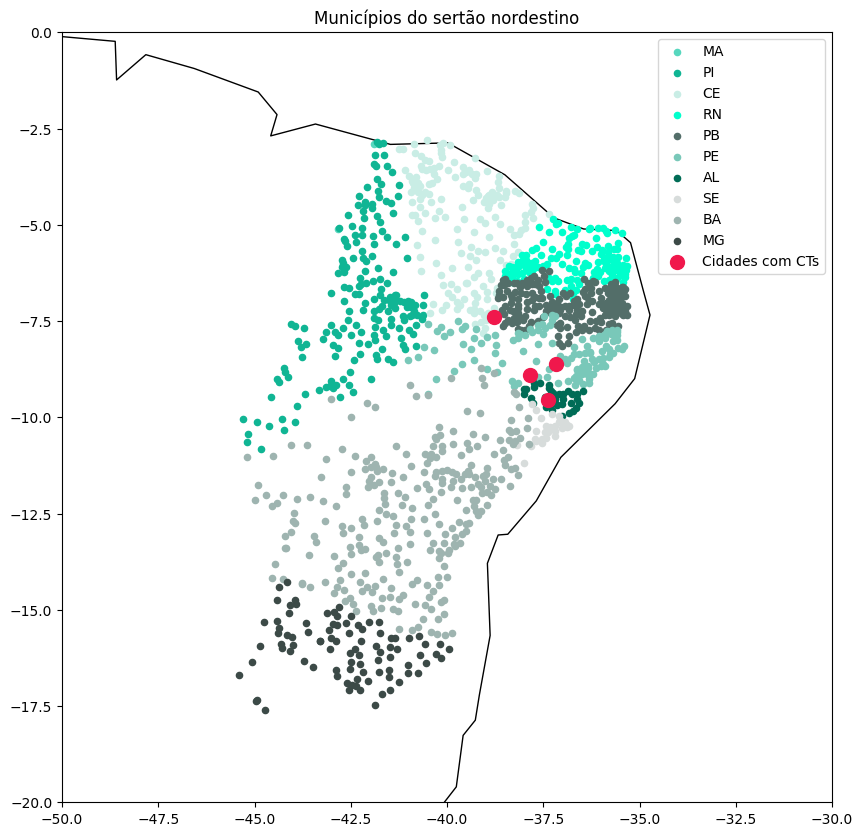

In [49]:
# Mapa com todos os municípios

filtered_df = df.copy()

geometry = [Point(xy) for xy in zip(filtered_df['longitude'], filtered_df['latitude'])]
gdf = gpd.GeoDataFrame(filtered_df, geometry=geometry)

extent = [-50, -30, -20, 0]
colors = [["MA", '#57D7BE'], ["PI", '#10B594'], ["CE", '#C9EDE5'], ['RN', '#00FFCC'], ['PB', '#536E69'], ['PE', '#79C8B9'], ['AL', '#006C56'], ['SE', '#D7DCDB'], ['BA', '#9EB4B0'], ['MG', '#3C4A47']]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(10, 10))
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

for code, color in colors:
    gdf[gdf['UF'] == code].plot(ax=ax, color=color, markersize=20, label=f'{code}')

gdf[gdf['IBGE7'].isin([2602803, 2607000, 2308104, 2708402])].plot(ax=ax, color='#F0184C', markersize=100, label='Cidades com CTs')

ax.legend()

plt.title("Municípios do sertão nordestino")
plt.show()

C:\Users\thoma\AppData\Local\Temp\ipykernel_3316\2697398646.py:11: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


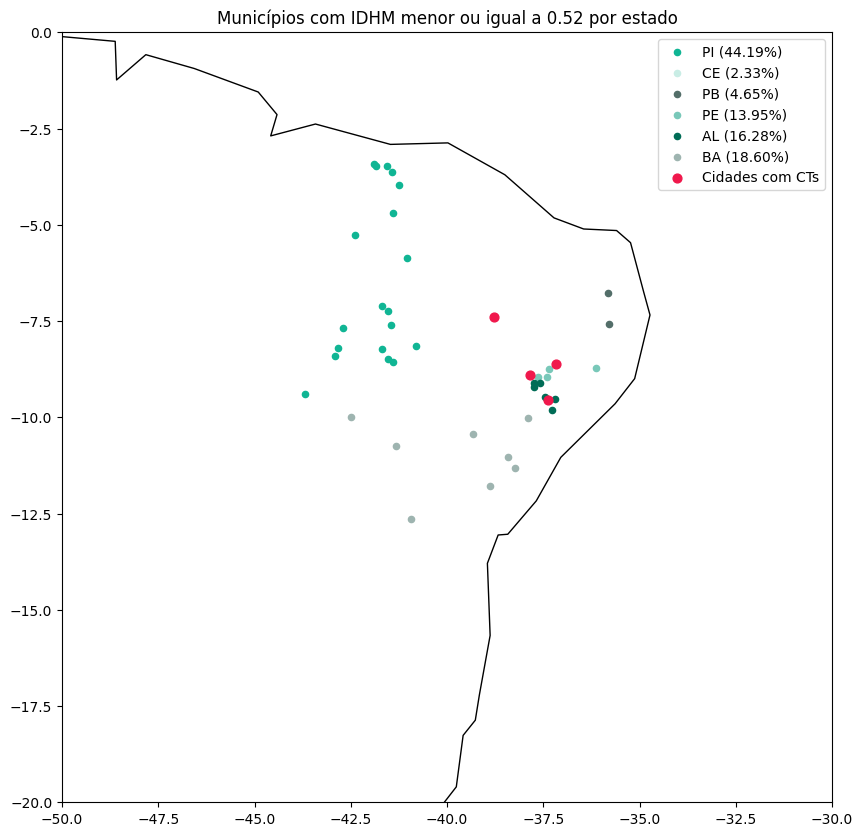

In [50]:
# Mapa com os municípios com IDHM <= 0.52

filtered_df = df[(df['IDHM'] <= 0.52) | df['IBGE7'].isin([2602803, 2607000, 2308104, 2708402])].copy()

geometry = [Point(xy) for xy in zip(filtered_df['longitude'], filtered_df['latitude'])]
gdf = gpd.GeoDataFrame(filtered_df, geometry=geometry)

extent = [-50, -30, -20, 0]
colors = [["MA", '#57D7BE'], ["PI", '#10B594'], ["CE", '#C9EDE5'], ['RN', '#00FFCC'], ['PB', '#536E69'], ['PE', '#79C8B9'], ['AL', '#006C56'], ['SE', '#D7DCDB'], ['BA', '#9EB4B0'], ['MG', '#3C4A47']]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(10, 10))
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

total_municipalities = len(gdf)
city_counts = gdf.groupby('UF')['geometry'].count().reset_index()
city_counts_dict = dict(zip(city_counts['UF'], (city_counts['geometry'] / total_municipalities) * 100))

for code, color in colors:
    if code in city_counts_dict:
        gdf[gdf['UF'] == code].plot(ax=ax, color=color, markersize=20, label=f'{code} ({city_counts_dict.get(code):.2f}%)')

gdf[gdf['IBGE7'].isin([2602803, 2607000, 2308104, 2708402])].plot(ax=ax, color='#F0184C', markersize=40, label=f'Cidades com CTs')

ax.legend()

plt.title("Municípios com IDHM menor ou igual a 0.52 por estado")
plt.show()

C:\Users\thoma\AppData\Local\Temp\ipykernel_3316\2545704688.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


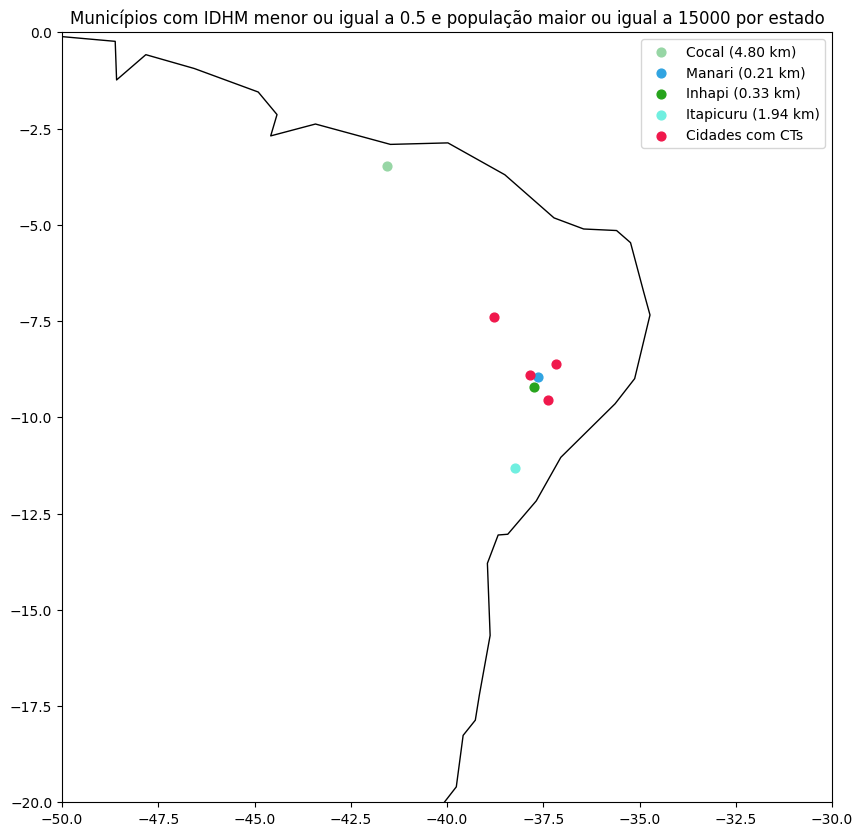

In [51]:
# Mapa com os municípios com IDHM <= 0.5 e população maior ou igual a 15000

filtered_df = df[((df['IDHM'] <= 0.5) & (df['POP_TOT'] >= 15000)) | df['IBGE7'].isin([2602803, 2607000, 2308104, 2708402])].copy()

geometry = [Point(xy) for xy in zip(filtered_df['longitude'], filtered_df['latitude'])]
gdf = gpd.GeoDataFrame(filtered_df, geometry=geometry)

extent = [-50, -30, -20, 0]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(10, 10))
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

unique_cities = gdf['NOME'].unique()
colors = plt.cm.viridis_r(range(len(unique_cities)))

random_colors = ['#%02X%02X%02X' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in unique_cities]
cities_with_ct = gdf[gdf['IBGE7'].isin([2602803, 2607000, 2308104, 2708402])]

for _, city in gdf.iterrows():
    if not city['IBGE7'] in [2602803, 2607000, 2308104, 2708402]:
        min_distance = cities_with_ct.distance(city['geometry']).min()
        label = f"{city['NOME']} ({min_distance:.2f} km)"
        city_color = '#%02X%02X%02X' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
        gdf[gdf['IBGE7'] == city['IBGE7']].plot(ax=ax, color=city_color, markersize=40, label=label)

gdf[gdf['IBGE7'].isin([2602803, 2607000, 2308104, 2708402])].plot(ax=ax, color='#F0184C', markersize=40, label=f'Cidades com CTs')

ax.legend()

plt.title("Municípios com IDHM menor ou igual a 0.5 e população maior ou igual a 15000 por estado")
plt.show()

C:\Users\thoma\AppData\Local\Temp\ipykernel_3316\3200677046.py:10: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


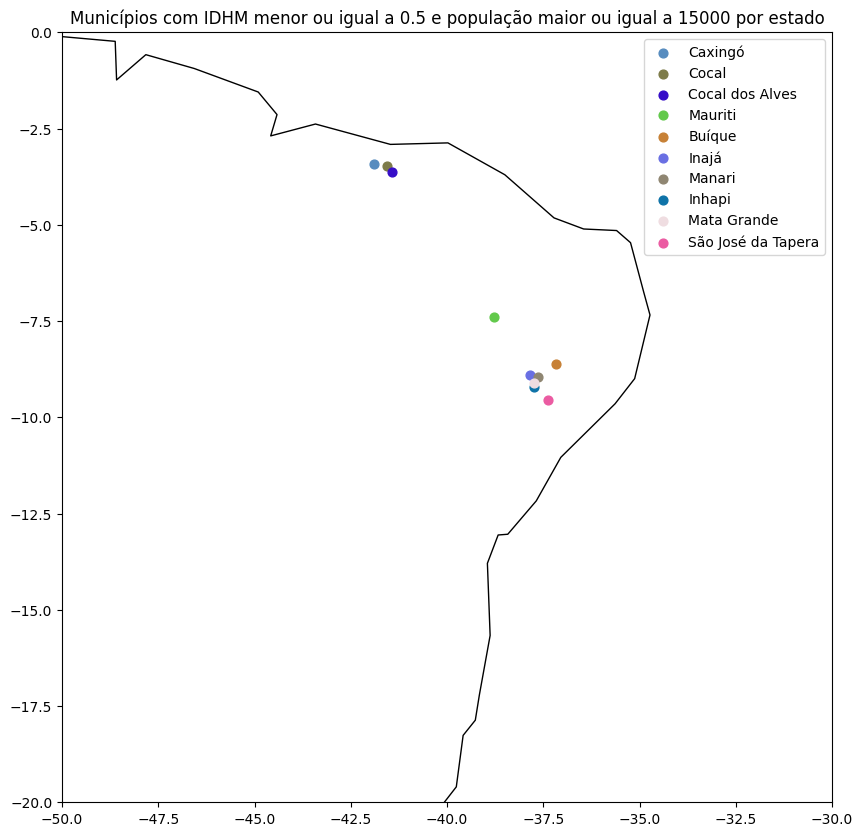

In [52]:
# Mapa com os municípios com IDHM <= 0.5 e população maior ou igual a 15000

filtered_df = df[(df['IBGE7'].isin([2202703, 2202729, 2202653, 2703304, 2705002, 2609154])) | df['IBGE7'].isin([2602803, 2607000, 2308104, 2708402])].copy()

geometry = [Point(xy) for xy in zip(filtered_df['longitude'], filtered_df['latitude'])]
gdf = gpd.GeoDataFrame(filtered_df, geometry=geometry)

extent = [-50, -30, -20, 0]

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
ax = world.plot(color='white', edgecolor='black', figsize=(10, 10))
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])

unique_cities = gdf['NOME'].unique()
colors = plt.cm.viridis_r(range(len(unique_cities)))

random_colors = ['#%02X%02X%02X' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255)) for _ in unique_cities]

for _, city in gdf.iterrows():
    label = f"{city['NOME']}"
    city_color = '#%02X%02X%02X' % (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))
    gdf[gdf['IBGE7'] == city['IBGE7']].plot(ax=ax, color=city_color, markersize=40, label=label)

ax.legend()

plt.title("Municípios com IDHM menor ou igual a 0.5 e população maior ou igual a 15000 por estado")
plt.show()